In [ ]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import cifar_nets
import training
import losses


NUM_CLASSES = 10
EPOCHS = 100

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [ ]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 512
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = False
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

class train_transform:
    def __init__(self, image_size):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=image_size, scale=(0.2, 1.0)),  # Random crop
            transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
            transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),  # Color distortions
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),  # CIFAR-10 normalization
        ])

    def __call__(self, img):
        """Returns two augmented views of the same image"""
        return self.transform(img), self.transform(img)  # Apply transform twice

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
])

In [6]:

train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=train_transform(32))
test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


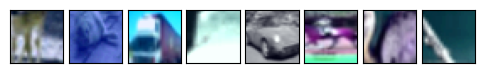

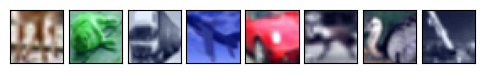

In [7]:

sample_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)

(imgs1,imgs2), _ = next(iter(sample_loader))

fig, _ = tensors_as_images(list(imgs1), figsize=(6,3))
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(imgs2), figsize=(6,3))
IPython.display.display(fig)
plt.close(fig)

In [8]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
# ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

dataset_size = len(train_dataset)
indices = np.arange(dataset_size)
np.random.shuffle(indices)  

train_size = int(0.8 * dataset_size)
train_indices, val_indices = indices[:train_size], indices[train_size:]

ds_train = torch.utils.data.Subset(train_dataset, train_indices) # using subset indices instead of random split to reuse later.
ds_val = torch.utils.data.Subset(train_dataset, val_indices)


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True, drop_last=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False, drop_last=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)


img_shape = train_dataset[0][0][0].shape



In [9]:

#Model
model = cifar_nets.ContrastiveEncoder(img_shape[0], args.latent_dim)

#Optimizer
optimizer = torch.optim.Adam(model.parameters())

#Loss
loss_fn = losses.NTXentLoss(batch_size=args.batch_size, temperature=0.1, device= args.device)

#Trainer
trainer = training.ContrastTrainer(model, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_contrast_encoder'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [10]:

model

ContrastiveEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=2048, out_features=128, bias=True)
    )
  )
  (projector): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [11]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=1,
                      checkpoints=checkpoint_file,)


--- EPOCH 1/1 ---
test_batch (Avg. Loss 4.846, Accuracy 0.1): 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
*** Saved checkpoint checkpoints/cifar_contrast_encoder.pt at epoch 1


now training regularly with no augmentations..

In [12]:
#Data

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])  
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
    ])


train_dataset.transform = transform
ds_train = torch.utils.data.Subset(train_dataset, train_indices) # reusing the same split
ds_val = torch.utils.data.Subset(train_dataset, val_indices)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)


In [13]:
#Model
encoder = model.encoder
for param in encoder.parameters():
    param.requires_grad = False  # Freezes encoder

classifier = cifar_nets.Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_contrast_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

--- EPOCH 1/1 ---
test_batch (Avg. Loss 1.538, Accuracy 44.2): 100%|██████████| 39/39 [00:03<00:00, 12.35it/s]
*** Saved checkpoint checkpoints/cifar_contrast_classifier.pt at epoch 1


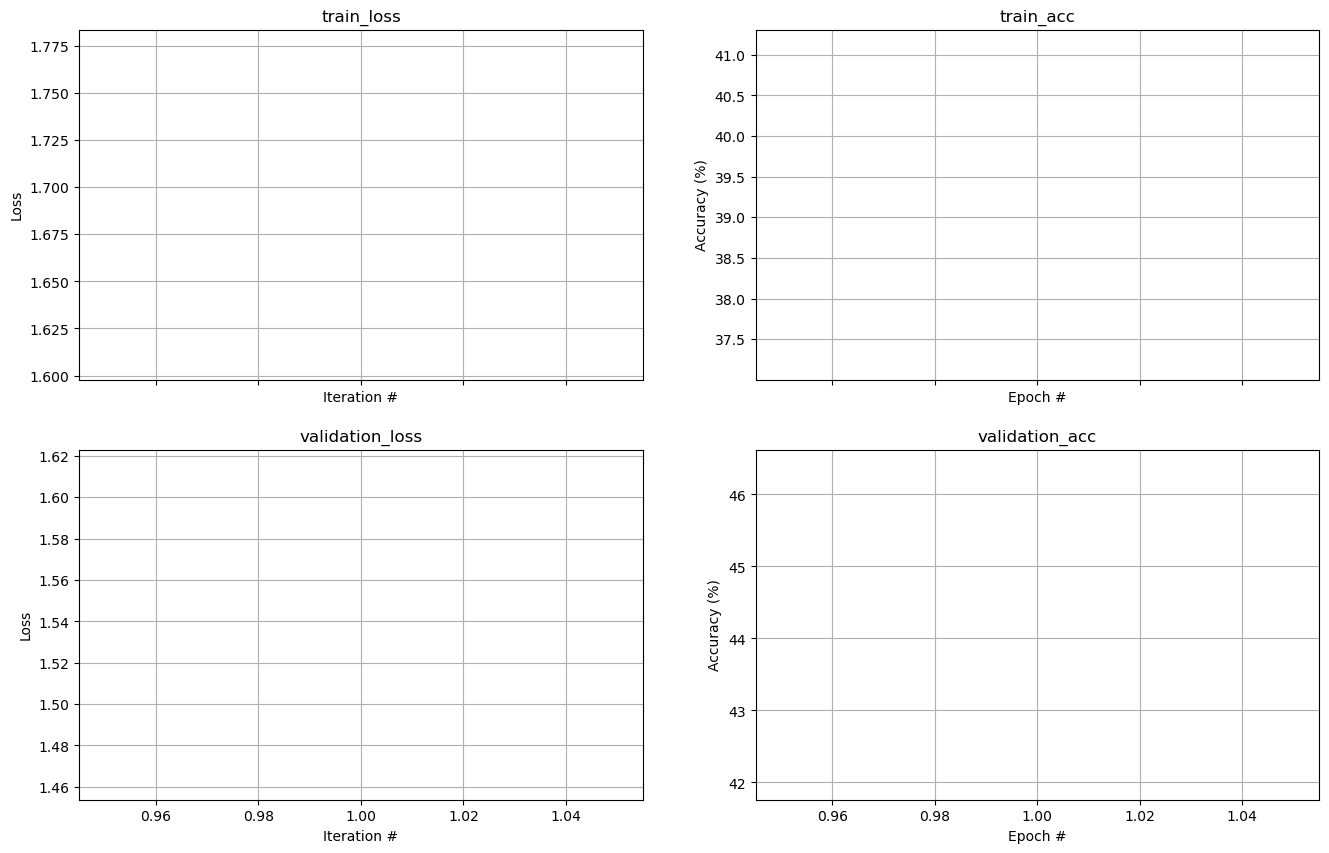

In [14]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)

# Evaluation


##  2. Quantitative Results

*** results from best model:


C:\Users\matan\AppData\Local\Temp\ipykernel_11964\1990524677.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'validation_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'validation_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

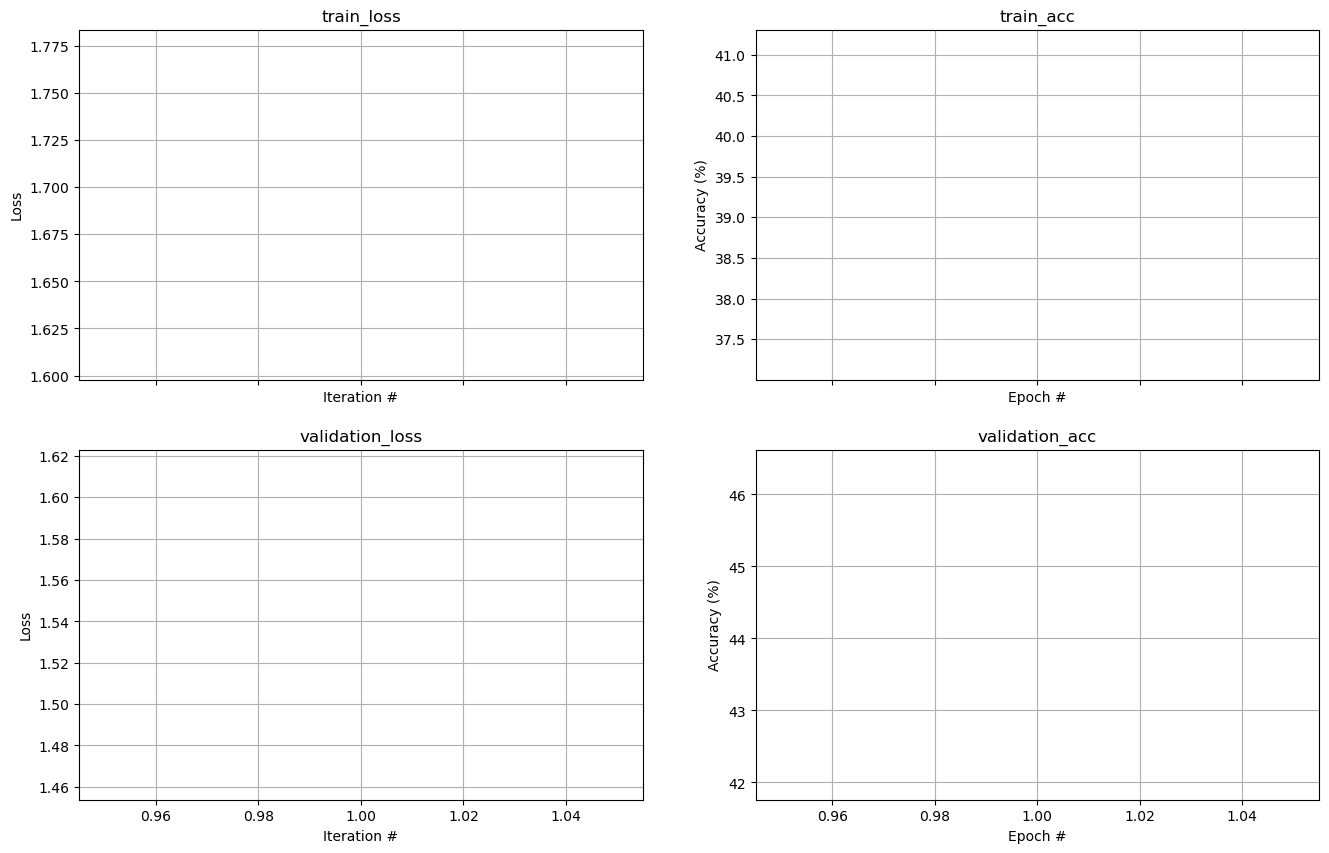

In [15]:

print('*** results from best model:')
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
res = saved_state['fit_result']
plot_fit(res)   

In [ ]:

res = trainer.test_epoch(dl_test)
print(f'Accuracy on test set: {res.accuracy:.2f}')
print(f' Accuracy on validation set: {saved_state['best_epoch_test_acc']}')
print(f' Accuracy on training set: {saved_state['best_epoch_train_acc']}')

test_batch (Avg. Loss 1.407, Accuracy 50.5): 100%|██████████| 313/313 [00:03<00:00, 82.88it/s]
Accuracy on test set: 50.46
Best model mean abs error: 0.2972



## 5. t-SNE

In [17]:
img_file = f"tsne_images/{checkpoint_file.replace('checkpoints/','')}"
if not os.path.isfile(f'{img_file}_latent_tsne.png'):
    plot_tsne(classifier.encoder, dl_test, args.device, img_file)